In [1]:
import warnings
import numpy as np

from astropy.modeling.functional_models import Moffat2D
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.table import Table

In [2]:
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]

# Load PSF Image

In [4]:
psf_file_path = '/astro/ferguson1/ferguson/dsii_dwarfs/HSC/psf-calexp-pdr2_dud-HSC-G-17130-3,0-242.84167-53.55806.fits'

In [5]:
psf_hdu_list = fits.open(psf_file_path)
psf_hdu = psf_hdu_list[0]
psf_data = psf_hdu.data

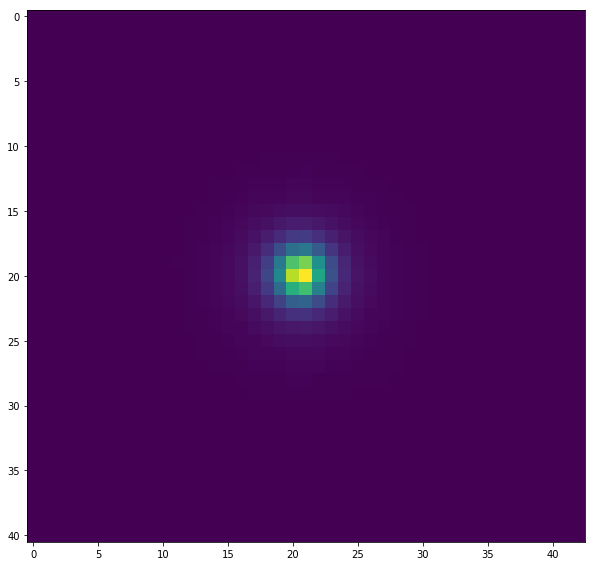

In [6]:
plt.imshow(psf_data)

# Preform Fitting

In [7]:
def find_center(array):
    return (np.array(array.shape)-1)/2

Mean Residual: -1.7046922612308543e-06


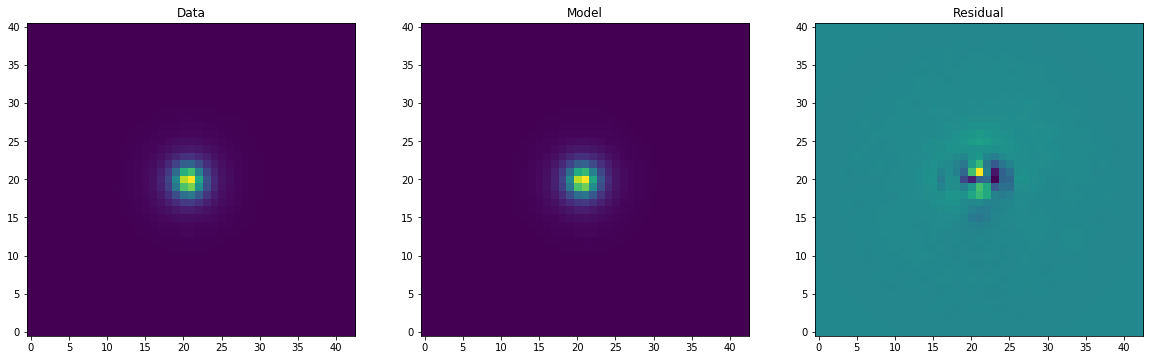

In [8]:
# Generate grid
x, y = np.mgrid[:psf_data.shape[0], :psf_data.shape[1]]
z = psf_data

center_x, center_y = find_center(z)

# Fit the data using astropy.modeling
p_init = Moffat2D(x_0=center_x, y_0=center_y)
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
vmin, vmax = z.min(), z.max()
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest')
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest')
plt.title("Residual")
print("Mean Residual:", (z - p(x, y)).mean())

In [9]:
Table(data=[p.param_names, p.parameters], names=["param_names", "param_vals"])

param_names,param_vals
str9,float64
amplitude,0.056331934281929064
x_0,19.869854849725694
y_0,20.653008026621922
gamma,2.3137418251638273
alpha,1.9318288844350466


# Generate Oversampled PSF

In [10]:
oversampling_factor = 4

In [11]:
# Generate new oversampled grid
new_x, new_y = np.mgrid[:psf_data.shape[0]*oversampling_factor, 
                        :psf_data.shape[1]*oversampling_factor]/oversampling_factor 

In [12]:
new_data = p(new_x, new_y)

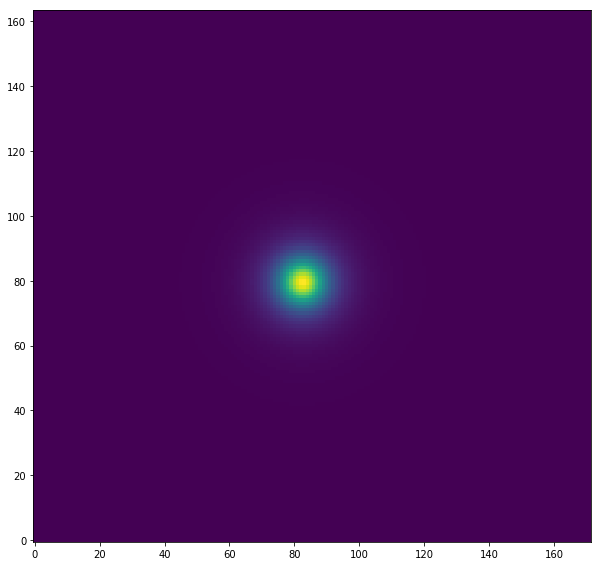

In [13]:
plt.imshow(new_data, origin='lower', interpolation='nearest')

# Write PSF to File

In [14]:
save_file_path = '/astro/ferguson1/ferguson/dsii_dwarfs/generated_data/moffat_oversampled_psf.fits'

In [15]:
psf_hdu.data = new_data

In [16]:
# Add fitted params to header
for name, value in zip(p.param_names, p.parameters):
    key = "MOFF{}".format(name.replace("_","")).upper()[:8]
    psf_hdu.header[key] = value
    psf_hdu.header.comments[key] = "Moffit {}".format(name)

In [17]:
psf_hdu.writeto(save_file_path, overwrite=True)

# Check New PSF Header

In [18]:
new_hdu = fits.open(save_file_path)[0]
new_header = new_hdu.header
assert(new_header['NAXIS1'] == new_data.shape[1])
assert(new_header['NAXIS2'] == new_data.shape[0])
new_header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  172 / length of data axis 1                          
NAXIS2  =                  164 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1A = 'LINEAR  '           / Type of projection                             
CTYPE2A = 'LINEAR  '           / Type of projection                             
CRPIX1A =                   1. / Column Pixel Coordinate of Reference           
CRPIX2A =                   1. / Row Pixel Coordinate of Reference              
CRVAL1A =               1362